# The Correlation Between School Locations and Chances for Students to Smoke

For this project, I want to study if there is a causal relationship between the location of the schools and the likelihood of students' smoking. I hypothesize that going to school in a rural area will decrease the chance of student smoking. 

Causal inference requires analysis on average treatment effect, bias and assumptions. The method I chose to approach the average treatment effect and conditional expectation function, is to approximate by regression models. 

## Data preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

%matplotlib inline
pd.options.mode.chained_assignment = None

The data I use is from 2018/2019 Canadian student tobacco, alcohol and drugs survey.

In [2]:
complete_df = pd.read_csv(r'C:\\Users\\Sirui Liu\\Desktop\\cst18_studentdata_en_pu_20190906.tab',sep='\t', engine='python')
complete_df.head()

,SCANID,MODULE,PROVID,SCHID,GRADE,SEX,SS_010,SS_020,TS_011,TV_010,...,DVTY2ST,DVLAST30,DVAMTSMK,DVCIGWK,DVNDSMK,DVAVCIGD,DVRES,DVURBAN,DVHHINC2,WTPP
0,100224,1,35,3589267,9,1,1,13,2,3,...,1,1,1,8,5,2,1,2,60000,33.15
1,100225,1,35,3589267,9,1,1,13,1,1,...,1,1,10,70,7,10,1,2,60000,33.15
2,100226,1,35,3589267,12,1,2,96,4,3,...,7,2,96,996,96,96,3,2,60000,75.14
3,100227,1,35,3589267,12,2,1,2,3,2,...,4,1,0,0,0,0,1,2,60000,105.70
4,100228,1,35,3589267,12,1,1,2,3,3,...,6,2,96,996,96,96,1,2,60000,75.14


There are 185 columns in total, and the variables I decide to mainly consider are "PROVID", "DVURBAN" and "DVTY1ST". 
- "PROVID" stands for the provinces that the survey was taken 
- "DVURBAN" tells if the school locates in the rural or urban area
- "DVTY1ST" describes the smoking status of an individual, which is then simplified to "curent smoker"  and "not current smoker" by me. 

In [3]:
df=complete_df[["PROVID","DVURBAN","DVTY1ST"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62850 entries, 0 to 62849
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   PROVID   62850 non-null  int64
 1   DVURBAN  62850 non-null  int64
 2   DVTY1ST  62850 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


The next part turns values into text so that it will be easier for me to make graphical representations.

In [4]:
df.loc[df['DVURBAN'] == 1,'DVURBAN']='Urban'
df.loc[df['DVURBAN'] == 2,'DVURBAN']='Rural'
df.loc[df['DVTY1ST'] == 1,'DVTY1ST']='Current_smoker'
df.loc[df['DVTY1ST'] == 2,'DVTY1ST']='Not_current_smoker'
df.loc[df['DVTY1ST'] == 3,'DVTY1ST']='Not_current_smoker'
df.loc[df['DVTY1ST'] == 99,'DVTY1ST']='Not_current_smoker'
df.loc[df['PROVID'] == 10,'PROVID']='Newfoundland_and_labrador'
df.loc[df['PROVID'] == 11,'PROVID']='Prince_edward_island'
df.loc[df['PROVID'] == 12,'PROVID']='Nova_scotia'
df.loc[df['PROVID'] == 13,'PROVID']='New_brunswick'
df.loc[df['PROVID'] == 24,'PROVID']='Québec'
df.loc[df['PROVID'] == 35,'PROVID']='Ontario'
df.loc[df['PROVID'] == 46,'PROVID']='Manitoba'
df.loc[df['PROVID'] == 47,'PROVID']='Saskatchewan'
df.loc[df['PROVID'] == 48,'PROVID']='Alberta'
df.loc[df['PROVID'] == 59,'PROVID']='British_columbia'

df.head(20)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62850 entries, 0 to 62849
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   PROVID   62850 non-null  object
 1   DVURBAN  62850 non-null  object
 2   DVTY1ST  62850 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


## Graphical Representations.

Urban and Rural is my treatment variable

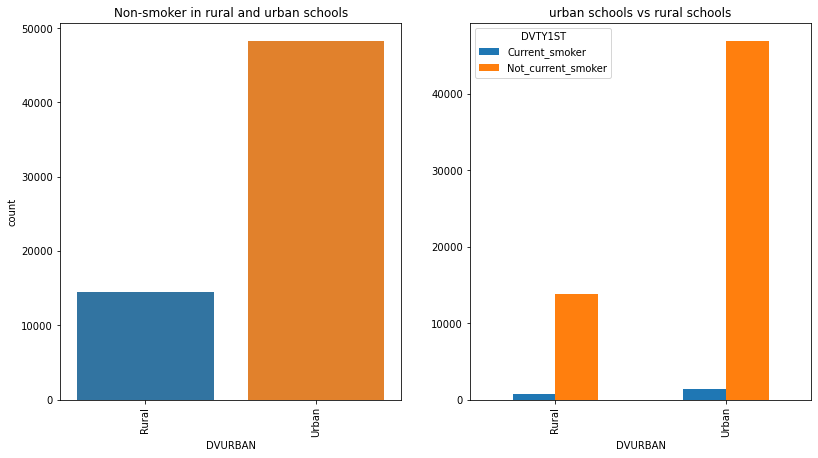

In [5]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
sns.countplot(x='DVURBAN',data=df,ax=ax[0])
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_title("Non-smoker in rural and urban schools")
pd.crosstab(df.DVURBAN,df.DVTY1ST).plot(kind='bar',ax=ax[1])
ax[1].set_title("urban schools vs rural schools")
fig.tight_layout(pad=3.0)

I will have provinces as controls. 

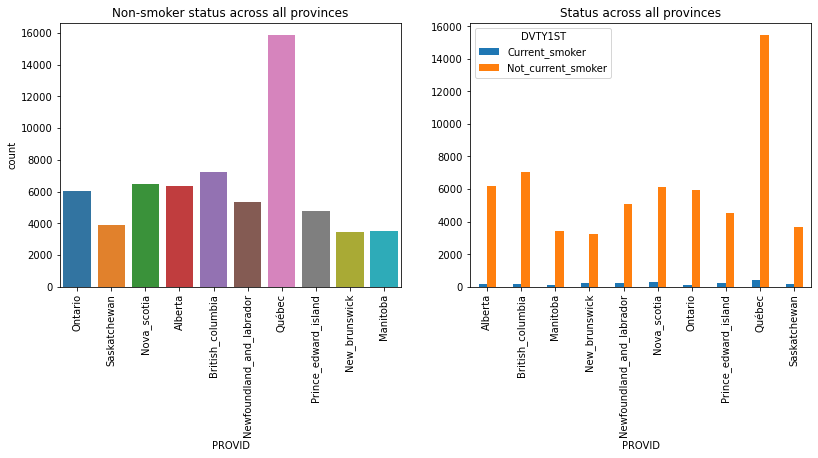

In [6]:
fig, ax = plt.subplots(1,2,figsize=(12,7))
sns.countplot(x='PROVID',data=df,ax=ax[0])
for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)
ax[0].set_title("Non-smoker status across all provinces")
pd.crosstab(df.PROVID,df.DVTY1ST).plot(kind='bar',ax=ax[1])
ax[1].set_title("Status across all provinces")
fig.tight_layout(pad=3.0)

## Display number of non-smokers in table

In [7]:
df.groupby(["DVURBAN","PROVID"])['DVTY1ST'].count().unstack(level="PROVID")

PROVID,Alberta,British_columbia,Manitoba,New_brunswick,Newfoundland_and_labrador,Nova_scotia,Ontario,Prince_edward_island,Québec,Saskatchewan
DVURBAN,,,,,,,,,,
Rural,1026,2144,718,1181,1585,1854,490,2267,805,2472
Urban,5292,5074,2800,2296,3736,4616,5573,2487,15038,1396


## Show number of non-smokers on map

In [8]:
import folium
import json # or import geojson

with open(r"C:\Users\Sirui Liu\Desktop\canada.geojson") as json_file:
    json_data = json.load(json_file) # geojson file

In [9]:
df.groupby(["PROVID"])['DVTY1ST'].count()

PROVID
Alberta                       6318
British_columbia              7218
Manitoba                      3518
New_brunswick                 3477
Newfoundland_and_labrador     5321
Nova_scotia                   6470
Ontario                       6063
Prince_edward_island          4754
Québec                       15843
Saskatchewan                  3868
Name: DVTY1ST, dtype: int64

In [10]:
count_non_smoker_data = {
  'Alberta':  6318,
  'British Columbia': 7218,
  'Manitoba': 3518,
  'New Brunswick': 3477,
  'Newfoundland and Labrador': 5321,
  'Northwest Territories': 0,
  'Nova Scotia': 6470,
  'Nunavut': 0,
  'Ontario': 6063,
  'Prince Edward Island':  4754,
  'Quebec':  15843,
  'Saskatchewan':3868,
  'Yukon Territory': 0
}

In [11]:
#Creaate a map object for choropleth map
#Set location to your location of interest (latitude and longitude )
can_map = folium.Map(location=[70.585901, -85.750596], zoom_start = 3)

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
folium.Choropleth(
  geo_data=json_data,
  data=count_non_smoker_data,
  columns=['Province', 'Non-smoker population'],
  key_on='feature.properties.name',
  fill_color='YlOrRd', 
  fill_opacity=0.7, 
  line_opacity=0.2,
  legend_name='Non-smoker distribution in Canada'
).add_to(can_map)

# display map
can_map


In [12]:
df = pd.get_dummies(df, columns = ['DVURBAN','PROVID','DVTY1ST'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62850 entries, 0 to 62849
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   DVURBAN_Rural                     62850 non-null  uint8
 1   DVURBAN_Urban                     62850 non-null  uint8
 2   PROVID_Alberta                    62850 non-null  uint8
 3   PROVID_British_columbia           62850 non-null  uint8
 4   PROVID_Manitoba                   62850 non-null  uint8
 5   PROVID_New_brunswick              62850 non-null  uint8
 6   PROVID_Newfoundland_and_labrador  62850 non-null  uint8
 7   PROVID_Nova_scotia                62850 non-null  uint8
 8   PROVID_Ontario                    62850 non-null  uint8
 9   PROVID_Prince_edward_island       62850 non-null  uint8
 10  PROVID_Québec                     62850 non-null  uint8
 11  PROVID_Saskatchewan               62850 non-null  uint8
 12  DVTY1ST_Current_smoker          

,DVURBAN_Rural,DVURBAN_Urban,PROVID_Alberta,PROVID_British_columbia,PROVID_Manitoba,PROVID_New_brunswick,PROVID_Newfoundland_and_labrador,PROVID_Nova_scotia,PROVID_Ontario,PROVID_Prince_edward_island,PROVID_Québec,PROVID_Saskatchewan,DVTY1ST_Current_smoker,DVTY1ST_Not_current_smoker
0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,0,0,0,1


## Regression analysis

In [13]:
X = df.loc[:, df.columns != 'DVTY1ST_Not_current_smoker'] # Includes all features except the response
y = df.loc[:, df.columns == 'DVTY1ST_Not_current_smoker']

In [14]:
# construct the model instance
lr_model = linear_model.LinearRegression()

# fit the model
lr_model.fit(X[["DVURBAN_Rural"]], y)

# print the coefficients
beta_0 = lr_model.intercept_
beta_1 = lr_model.coef_[0]

print("beta_0:",beta_0)
print("beta_1:",beta_1)
print("Linear_regression model: DVTY1ST_Not_current_smoker = 0.97232342 - 0.02300421 DVURBAN_Rural")

beta_0: [0.97232342]
beta_1: [-0.02300421]
Linear_regression model: DVTY1ST_Not_current_smoker = 0.97232342 - 0.02300421 DVURBAN_Rural


In [15]:
#lasso regression for controls pertaining to population
lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(X), lasso_model.coef_)))
coefs = pd.DataFrame(lasso_coefs)
coefs

,0
DVURBAN_Rural,-0.0
DVURBAN_Urban,0.0
PROVID_Alberta,0.0
PROVID_British_columbia,0.0
PROVID_Manitoba,0.0
PROVID_New_brunswick,-0.0
PROVID_Newfoundland_and_labrador,-0.0
PROVID_Nova_scotia,-0.0
PROVID_Ontario,0.0
PROVID_Prince_edward_island,-0.0


In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

logistic_model = linear_model.LogisticRegression(solver="lbfgs")
logistic_model.fit(X_train, y_train.values.ravel())


beta_0 = logistic_model.intercept_[0]
beta_1 = logistic_model.coef_[0][0]

print("beta_0:",beta_0)
print("beta_1:",beta_1)
print("logistic model: DVTY1ST_Not_current_smoker = 8.089287907158871  -0.12256895629487825 DVURBAN_Rural")

beta_0: 8.089112249005064
beta_1: -0.1235545323501669
logistic model: DVTY1ST_Not_current_smoker = 8.089287907158871  -0.12256895629487825 DVURBAN_Rural


In [17]:
report = metrics.classification_report(
    y_train, logistic_model.predict(X_train),
    target_names=["No smoking", "smoking"]
)
print(report)

              precision    recall  f1-score   support

  No smoking       1.00      1.00      1.00      1583
     smoking       1.00      1.00      1.00     45554

    accuracy                           1.00     47137
   macro avg       1.00      1.00      1.00     47137
weighted avg       1.00      1.00      1.00     47137



## Some reflection on my regression analysis and ways to improve

I did a very simple linear regression, a lasso regression and a logistic regression. I don't think these are good enough to have a conclusion on correlation or causation. In fact, I think that might be other ways to improve my regression analysis. 

One factor that leads to not very ideal results is that all my variables and potential outcomes are discrete. At first, I think this is doable because logistic regression is supposed to deal with this situation. However, when I actually proceed with my data, it's hard to graph. I realize that I should probably change my data frame. I think it will be better if I have my potential outcomes in counts of people, rather than discrete smokers and non-smokers. I still think my regression models are valid approaches, but if I have another chance, I will work on dataframe more.